# Lab 3: Extending Logistic Regression
## by Michael Doherty, Leilani Guzman, and Carson Pittman

## 1. Business Understanding

In 1633, the Japanese government, feeling threatened by Spanish and Portugese influence within their country, banned foreign goods as part of their isolationist foreign policy (called [Sakoku](https://en.wikipedia.org/wiki/Sakoku)). As part of this ban, European playing cards were forbidden, so Japanese playing cards, called [hanafuda](https://lammuseum.wfu.edu/2021/12/japanese-hanafuda-cards/), were developed; however, hanafuda struggled to gain popularity among the Japanese populace. Centuries later, on November 22, 1859 in Kyoto, Japan, a man named Fusajiro Yamauchi was born. An aspiring artist and entrepreneur, Yamauchi saw an opportunity with hanafuda, so in 1889 he opened a shop to sell his own handcrafted cards. What was the name of that shop? [Nintendo Koppai](https://www.lifewire.com/fusajiro-yamauchi-founder-of-nintendo-729584) (which was later shortened to just Nintendo).

While Fusajiro Yamauchi would never know it, his card company would eventually become one of the biggest video game companies in the world. Since the mid-twentieth century, advancements in technology have propelled video games to become a multi-billion dollar industry. Yet, not all video games are made equal; from sports games like the [FIFA series](https://en.wikipedia.org/wiki/FIFA_(video_game_series)) to puzzle games like [Tetris](https://en.wikipedia.org/wiki/Tetris), there are several genres that a video game can belong to.

The dataset we've selected, titled "Global Video Game Sales", was created to analyze how a video game's genre relates to the platform it was released on, its publisher, and its sales (both globally and in various regions). The dataset consists of 16,600 instances with 11 multivariate attributes, comprised of numeric and categorical data types.

Ultimately, the prediction task for this dataset is to determine what a video game's genre is. Who might be interested in this research? For starters, video game companies may be interested to see which video game genre has the best sales. They may also find that certain genres are more popular in some markets than others (such as puzzle games being popular in Japan and sports games being popular in Europe). This information can help inform their strategies on what types of games they should make and where they should focus their marketing efforts. The prediction model created would be mostly used for offline analysis (as there aren't enough video games being created all the time that would justify having a deployed model).

So what does a good prediction algorithm for this dataset look like? There are several factors that need to be considered:
- **Finding Useful Trends**: One of the most important factors for the prediction algorithm is being able to find clear trends relating to a video game's genre. For example, finding that Nintendo games sell best in Japan, or that the most profitable video game genre is Shooter games, would be useful information that video game companies could use to make decisions regarding future video games, where to market their products more, etc.
- **Accuracy**: How accurate the prediction algorithm is at classifying video game genres is one of the most important aspects. The more accurate the prediction algorithm is, the more reliable the trends will be that we derive from the prediction algorithm. Thus, we want the accuracy to be as high as possible; at minimum, it should be higher than 50%, and ideally it would have  an accuracy greater than 90%.  

Thus, there are several aspects that need to be considered when trying to create a reliable prediction model. The data derived from the model should help companies make informed decisions on what types of video games to make, where they should advertise certain types of games more heavily, Ultimately, any good prediction model would need to prove useful to video game companies by providing useful insights that can help them increase their profits.

Link to the dataset: https://www.kaggle.com/datasets/thedevastator/global-video-game-sales

## 2. Data Preparation

In [1]:
import pandas as pd

df = pd.read_csv("data/vgsales.csv")

df.info()
df[df["Year"].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
179,180,Madden NFL 2004,PS2,NaN,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23
377,378,FIFA Soccer 2004,PS2,NaN,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49
431,432,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,1.86,1.02,0.00,0.29,3.17
470,471,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,NaN,1.57,1.02,0.00,0.41,3.00
607,608,Space Invaders,2600,NaN,Shooter,Atari,2.36,0.14,0.00,0.03,2.53
...,...,...,...,...,...,...,...,...,...,...,...
16307,16310,Freaky Flyers,GC,NaN,Racing,Unknown,0.01,0.00,0.00,0.00,0.01
16327,16330,Inversion,PC,NaN,Shooter,Namco Bandai Games,0.01,0.00,0.00,0.00,0.01
16366,16369,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,Unknown,0.01,0.00,0.00,0.00,0.01
16427,16430,Virtua Quest,GC,NaN,Role-Playing,Unknown,0.01,0.00,0.00,0.00,0.01


As shown above, there is missing data for both the <code>Year</code> and <code>Publisher</code> attributes. The dataset is currently split up by <code>Platform</code> (meaning that Grand Theft Auto V on the Xbox 360 and Grand Theft Auto V on the PlayStation 4 are two separate rows, each with their own sales data, even though they are the same game). Some of the missing data can thus be found by looking at other rows about the same video game. For example, as seen above, Madden NFL 2004 on the PlayStation 2 is missing a <code>Year</code> attribute, but by looking at other rows for Madden NFL 2004 (such as the row for its release on the Xbox), we can see that the game released in 2003.

Since most video games are released on a multitude of platforms, and the sales data for this dataset is split up by platform, we decided to aggregate the data and drop the <code>Platform</code> attribute. In doing so, we can fill in some of the missing data and reduce the size of our dataset. We also believe that total sales data (regardless of platform) is much more important to determining a video game's genre than the platform the video game released on (as most games released on Xbox consoles are also released on PlayStation consoles, some games might have lower sales on a certain console because a newer console had recently been released by that point, etc.). Because of this aggregation, the <code>Rank</code> attribute is also no longer relevant (as it is based on the total sales data for each video game, which we are modifying when we aggregate the data, meaning <code>Rank</code> is no longer accurate). Thus, we will aggregate the data and drop the <code>Platform</code> and <code>Rank</code> columns.

In [2]:
#Data Cleaning with Aggregation

df = df.groupby("Name").aggregate({'Rank': 'first', 'Platform': 'first', 'Name': 'first', 'Year': 'first', 'Genre': 'first', 'Publisher': 'last', 'NA_Sales': 'sum', 'EU_Sales': 'sum', 'JP_Sales': 'sum', 'Other_Sales': 'sum', 'Global_Sales': 'sum' })
del df["Platform"]
del df["Rank"]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11493 entries, '98 Koshien to ¡Shin Chan Flipa en colores!
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          11493 non-null  object 
 1   Year          11360 non-null  float64
 2   Genre         11493 non-null  object 
 3   Publisher     11442 non-null  object 
 4   NA_Sales      11493 non-null  float64
 5   EU_Sales      11493 non-null  float64
 6   JP_Sales      11493 non-null  float64
 7   Other_Sales   11493 non-null  float64
 8   Global_Sales  11493 non-null  float64
dtypes: float64(6), object(3)
memory usage: 897.9+ KB


Since there is still some missing data, we decided to drop these rows, as after aggregating the data, any video games missing their <code>Publisher</code> or <code>Year</code> are probably fairly obscure games and could be regarded as outliers; additionally, we have plenty of data to work with, even after dropping the rows with missing data.

In [3]:
#Removing Null Values

df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11325 entries, '98 Koshien to ¡Shin Chan Flipa en colores!
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          11325 non-null  object 
 1   Year          11325 non-null  float64
 2   Genre         11325 non-null  object 
 3   Publisher     11325 non-null  object 
 4   NA_Sales      11325 non-null  float64
 5   EU_Sales      11325 non-null  float64
 6   JP_Sales      11325 non-null  float64
 7   Other_Sales   11325 non-null  float64
 8   Global_Sales  11325 non-null  float64
dtypes: float64(6), object(3)
memory usage: 884.8+ KB


The data types above are accurate except for year, which is stored as a float. Since this set only has integer years, we change the years to be an integer.

In [4]:
df = df.astype({'Year': 'int'})
df.head()

,Name,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Name,,,,,,,,,
'98 Koshien,'98 Koshien,1998,Sports,Magical Company,0.15,0.10,0.12,0.03,0.41
.hack//G.U. Vol.1//Rebirth,.hack//G.U. Vol.1//Rebirth,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17
.hack//G.U. Vol.2//Reminisce,.hack//G.U. Vol.2//Reminisce,2006,Role-Playing,Namco Bandai Games,0.11,0.09,0.00,0.03,0.23
.hack//G.U. Vol.2//Reminisce (jp sales),.hack//G.U. Vol.2//Reminisce (jp sales),2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.16,0.00,0.16
.hack//G.U. Vol.3//Redemption,.hack//G.U. Vol.3//Redemption,2007,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17


Next, we need to one-hot encode our categorical data so it can be used in our Logistic Regression  algorithms. Thus, we will one-hot encode the <code>Publisher</code> attributes of our data. This allows for the algorithm to use it as numeric data.

In [5]:
#One Hot Encoding

df_onehot = pd.get_dummies(df, columns=['Publisher'])

df_onehot.head()

,Name,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Publisher_10TACLE Studios,Publisher_1C Company,...,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,"Publisher_mixi, Inc",Publisher_responDESIGN
Name,,,,,,,,,,,,,,,,,,,,,
'98 Koshien,'98 Koshien,1998,Sports,0.15,0.10,0.12,0.03,0.41,0,0,...,0,0,0,0,0,0,0,0,0,0
.hack//G.U. Vol.1//Rebirth,.hack//G.U. Vol.1//Rebirth,2006,Role-Playing,0.00,0.00,0.17,0.00,0.17,0,0,...,0,0,0,0,0,0,0,0,0,0
.hack//G.U. Vol.2//Reminisce,.hack//G.U. Vol.2//Reminisce,2006,Role-Playing,0.11,0.09,0.00,0.03,0.23,0,0,...,0,0,0,0,0,0,0,0,0,0
.hack//G.U. Vol.2//Reminisce (jp sales),.hack//G.U. Vol.2//Reminisce (jp sales),2006,Role-Playing,0.00,0.00,0.16,0.00,0.16,0,0,...,0,0,0,0,0,0,0,0,0,0
.hack//G.U. Vol.3//Redemption,.hack//G.U. Vol.3//Redemption,2007,Role-Playing,0.00,0.00,0.17,0.00,0.17,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally, We scaled our numeric data to prevent the larger values from affecting the model as much as the smaller values. Scaling will help to prevent the model from being biased towards certain attributes over others.

Our final dataset is described below. It shows how there is no missing data because the columns all have the same count. It also shows the mean, standard deviation, min, max, and quartile information. This table shows how much larger the year values are to all other values in this dataset. The other numbers are closer in scale, but should still be scaled to ensure there is no bias.

In [6]:
df_onehot.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Publisher_10TACLE Studios,Publisher_1C Company,Publisher_20th Century Fox Video Games,Publisher_2D Boy,...,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,"Publisher_mixi, Inc",Publisher_responDESIGN
count,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,...,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000
mean,2005.633819,0.384970,0.213965,0.113571,0.070151,0.783050,0.000265,0.000265,0.000442,0.000088,...,0.002472,0.001148,0.000265,0.000442,0.000088,0.000088,0.000088,0.000177,0.000088,0.000088
std,6.099033,1.179826,0.767471,0.389027,0.275877,2.255285,0.016274,0.016274,0.021008,0.009397,...,0.049664,0.033863,0.016274,0.021008,0.009397,0.009397,0.009397,0.013289,0.009397,0.009397
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2002.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2007.000000,0.070000,0.020000,0.000000,0.010000,0.190000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2010.000000,0.300000,0.130000,0.070000,0.040000,0.620000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,41.490000,29.020000,10.220000,10.720000,82.740000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The values in the dataset are now scaled and all have a mean of zero and a standard deviation of 1. After the scaling, this is the data we will use in our model.

In [7]:
from sklearn.preprocessing import StandardScaler

#Scale all of the numeric data to prevent bias in the model
scaler = StandardScaler()

df_onehot[["Year", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]] = scaler.fit_transform(df_onehot[["Year", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]])

df_onehot.head()

,Name,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Publisher_10TACLE Studios,Publisher_1C Company,...,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,"Publisher_mixi, Inc",Publisher_responDESIGN
Name,,,,,,,,,,,,,,,,,,,,,
'98 Koshien,'98 Koshien,-1.251699,Sports,-0.199166,-0.148500,0.016527,-0.145546,-0.165419,0,0,...,0,0,0,0,0,0,0,0,0,0
.hack//G.U. Vol.1//Rebirth,.hack//G.U. Vol.1//Rebirth,0.060042,Role-Playing,-0.326309,-0.278804,0.145058,-0.254295,-0.271840,0,0,...,0,0,0,0,0,0,0,0,0,0
.hack//G.U. Vol.2//Reminisce,.hack//G.U. Vol.2//Reminisce,0.060042,Role-Playing,-0.233070,-0.161531,-0.291949,-0.145546,-0.245235,0,0,...,0,0,0,0,0,0,0,0,0,0
.hack//G.U. Vol.2//Reminisce (jp sales),.hack//G.U. Vol.2//Reminisce (jp sales),0.060042,Role-Playing,-0.326309,-0.278804,0.119352,-0.254295,-0.276274,0,0,...,0,0,0,0,0,0,0,0,0,0
.hack//G.U. Vol.3//Redemption,.hack//G.U. Vol.3//Redemption,0.224010,Role-Playing,-0.326309,-0.278804,0.145058,-0.254295,-0.271840,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_onehot.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Publisher_10TACLE Studios,Publisher_1C Company,Publisher_20th Century Fox Video Games,Publisher_2D Boy,...,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,"Publisher_mixi, Inc",Publisher_responDESIGN
count,1.132500e+04,1.132500e+04,1.132500e+04,1.132500e+04,1.132500e+04,1.132500e+04,11325.000000,11325.000000,11325.000000,11325.000000,...,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000
mean,1.648773e-14,2.886090e-17,-1.129339e-17,-1.003857e-17,3.638983e-17,-1.380304e-17,0.000265,0.000265,0.000442,0.000088,...,0.002472,0.001148,0.000265,0.000442,0.000088,0.000088,0.000088,0.000177,0.000088,0.000088
std,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00,0.016274,0.016274,0.021008,0.009397,...,0.049664,0.033863,0.016274,0.021008,0.009397,0.009397,0.009397,0.013289,0.009397,0.009397
min,-4.203117e+00,-3.263087e-01,-2.788043e-01,-2.919486e-01,-2.542950e-01,-3.427877e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.958288e-01,-3.263087e-01,-2.788043e-01,-2.919486e-01,-2.542950e-01,-3.206166e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.240095e-01,-2.669753e-01,-2.527436e-01,-2.919486e-01,-2.180453e-01,-2.629717e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.159125e-01,-7.202264e-02,-1.094093e-01,-1.120046e-01,-1.092963e-01,-7.229999e-02,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.355589e+00,3.484145e+01,3.753539e+01,2.597989e+01,3.860535e+01,3.634156e+01,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


These metrics are useful to quantify the numeric data, but they do nothing for the categorical data. The histogram below shows the distribution of the genre data

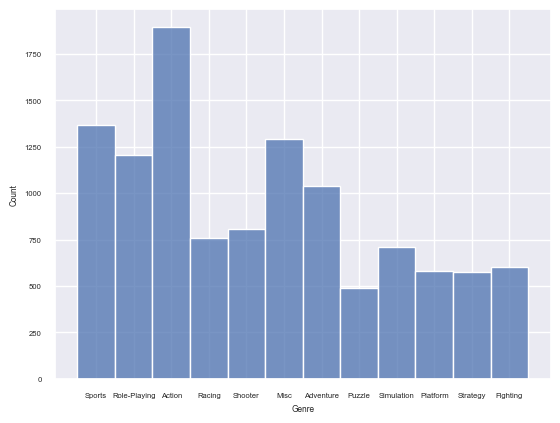

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = .5)
sns.histplot(df.Genre)
plt.show()

Our final dataset includes the following data:

-Name stored as a string

-Year stored as a float and scaled

-Genre stored as a string

-NA_Sales, EU_Sales, JP_Sales, Other_Sales, and Global_Sales all stored as a float and scaled

-Publisher stored as a one-hot encoding

## 3. Modeling

In [52]:
import numpy as np
from scipy.special import expit

# Binary Logistic Regression using vectorized implementation

class BinaryLogisticRegression:
    # Adjust default values for iterations and C as needed
    def __init__(self, eta, iterations=20, C=0.001, penalty='l2'):
        self.eta = eta          # The learning rate
        self.iterations = iterations
        self.C = C
        self.penalty = penalty
    def __str__(self):
        if(hasattr(self, 'weights_')):
            return "Binary Logistic Regression Object with coefficients:\n" + str(self.weights_)
        return 'Binary Logistic Regression Object is untrained'
    
    @staticmethod
    def _add_bias(X):
        # Add a column of float ones to X
        return np.hstack((np.ones((X.shape[0],1)), X))
    
    @staticmethod
    def _sigmoid(theta):
        return expit(theta)
    
    def _get_gradient(self, X, y):
        y_diff = y - self.predict_proba(X, add_bias=False).ravel()
        gradient = np.mean(X * y_diff[:,np.newaxis], axis = 0)
        gradient = gradient.reshape(self.weights_.shape)
        # Based on penalty type, add the appropriate term to the gradient
        if self.penalty == 'l1':
            # Double check this, not sure
            gradient[1:] += self.C * sum(abs(self.weights_[1:]))
        elif self.penalty == 'l2':
            # Double check this, not sure
            gradient[1:] += self.C * sum(self.weights_[1:]**2)
        elif self.penalty == 'both':
            gradient[1:] += self.C * sum(self.weights_[1:]**2) + self.C * sum(abs(self.weights_[1:]))
        elif self.penalty == 'none':
            pass
        return gradient
    
    def predict_proba(self, X, add_bias=True):
        X_bias = self._add_bias(X) if add_bias else X
        return self._sigmoid(X_bias @ self.weights_)
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5)
    
    def fit(self, X, y):
        X_bias = self._add_bias(X)
        num_samples, num_features = X_bias.shape
        self.weights_ = np.zeros((num_features,1))    # Creating the weight vector

        for _ in range(self.iterations):
            gradient = self._get_gradient(X_bias, y)
            self.weights_ += self.eta * gradient
    

In [53]:
from numpy import ma
from scipy.optimize import minimize_scalar

## Optimizing 1: Steepest Ascent/Line Search

class LineSearchLogisticRegression(BinaryLogisticRegression):
    def __init__(self, line_iterations=0.0, **kwds):
        self.line_iterations = line_iterations
        super().__init__(**kwds)

        @staticmethod
        def objective_function(eta, X, y, w, gradient, C):
            w_new = w - gradient*eta
            gradient_new = expit(X @ w_new)
            return -np.sum(ma.log(gradient_new[y==1]))-ma.sum(ma.log(1-gradient_new[y==0])) + C*sum(w_new**2)
        
        def fit(self, X, y):
            X_bias = self._add_bias(X)
            num_samples, num_features = X_bias.shape
            self.weights_ = np.zeros((num_features,1))

            for _ in range (self.iterations):
                gradient = -self._get_gradient(X_bias, y)
                opts = {'maxiter': self.line_iterations}
                res = minimize_scalar(self.objective_function,
                                      bounds=(0,self.eta*10),
                                      args=(X_bias, y, self.weights_, gradient, self.C),
                                      method='bounded',
                                      options=opts)
                
            eta = res.x
            self.weights_ -= eta*gradient

In [54]:
## Optimizing 2: Stoachastic Gradient Ascent

class StochasticLogisticRegression(BinaryLogisticRegression):
    def _get_gradient(self, X, y):
        # Adjust batch size as needed, calculates gradient according to this batch size
        batch_size = 16
        idxs = np.random.choice(len(y), batch_size)

        y_diff = y[idxs] - self.predict_proba(X[idxs], add_bias=False).ravel()
        gradient= np.mean(X[idxs] * y_diff[:,np.newaxis], axis = 0)

        gradient = gradient.reshape(self.weights_.shape)
        if self.penalty == 'l1':
            # Double check this, not sure
            gradient[1:] += self.C * sum(abs(self.weights_[1:]))
        elif self.penalty == 'l2':
            # Double check this, not sure
            gradient[1:] += self.C * sum(self.weights_[1:]**2)
        elif self.penalty == 'both':
            gradient[1:] += self.C * sum(self.weights_[1:]**2) + self.C * sum(abs(self.weights_[1:]))
        elif self.penalty == 'none':
            pass

        # This might need to be negative?
        return gradient

In [55]:
from scipy.optimize import fmin_bfgs
## Optimizing 3: Quasi-Newton Method (BFGS)

class BFGSLogisticRegression(BinaryLogisticRegression):

    @staticmethod
    def objective_function(w, X, y, C, penalty):
        gradient = expit(X @ w)
        return -ma.sum(ma.log(gradient[y==1])-ma.sum(ma.log(1-gradient[y==0]))) + C*sum(w**2)
    
    @staticmethod
    def objective_gradient(w, X, y, C, penalty):
        gradient = expit(X @ w)
        y_diff = y-gradient
        gradient = np.mean(X * y_diff[:,np.newaxis], axis = 0)
        gradient = gradient.reshape(w.shape)
        if penalty == 'l1':
            # Double check this, not sure
            gradient[1:] += C * sum(abs(w[1:]))
        elif penalty == 'l2':
            # Double check this, not sure
            gradient[1:] += C * sum(w[1:]**2)
        elif penalty == 'both':
            gradient[1:] += C * sum(w[1:]**2) + C * sum(abs(w[1:]))
        elif penalty == 'none':
            pass
        return -gradient
    
    def fit(self, X, y):
        X_bias = self._add_bias(X)
        num_samples, num_features = X_bias.shape
        self.weights_ = fmin_bfgs(self.objective_function,
                                  np.zeros((num_features,1)),
                                  fprime=self.objective_gradient,
                                  args=(X_bias, y, self.C, self.penalty),
                                  gtol=1e-03,
                                  maxiter=self.iterations,
                                  disp=False)
        self.weights_ = self.weights_.reshape((num_features,1))

In [56]:
#Regularized Logistic Regression using vectorized implementation
class MultiClassLogisticRegression:
    # Adjust default values for iterations and C as needed, temp default for solver is LineSearchLogisticRegression
    # Penalty can be either 'l1' or 'l2' or 'both', default to 'l2' for now (these are passed to the solver)
    def __init__(self, **kwds):
        self.eta = kwds.get('eta', 0.01)  # The learning rate
        self.iterations = kwds.get('iterations', 20)
        self.line_iterations = kwds.get('line_iterations', 0.0)
        self.C = kwds.get('C', 0.001)
        self.penalty = kwds.get('penalty', 'l2')
        self.solver = kwds.get('solver', LineSearchLogisticRegression)
        self.classifiers_ = []

    def __str__(self):
        if(hasattr(self, 'weights_')):
            return "Multiclass Logistic Regression Object with coefficients:\n" + str(self.weights_)
        return 'Multiclass Logistic Regression Object is untrained'
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_classes_ = np.sort(np.unique(y))
        num_unique_classes = len(self.unique_classes_)
        self.classifiers_ = []

        for i, y_value in enumerate(self.unique_classes_):
            # One vs All
            y_binary = np.array(y==y_value).astype(int)
            # Only pass line_iterations to solver if it is not 0.0
            
            if self.line_iterations == 0.0:
                lr = self.solver(eta=self.eta, iterations=self.iterations, C=self.C, penalty=self.penalty)
            else:
                lr = self.solver(eta=self.eta, iterations=self.iterations, line_iterations=self.line_iterations, C=self.C, penalty=self.penalty)
            lr.fit(X, y_binary)
            self.classifiers_.append(lr)
        
        self.weights_ = np.hstack([x.weights_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probabilities = []
        for lr in self.classifiers_:
            probabilities.append(lr.predict_proba(X).reshape((len(X),1)))
        return np.hstack(probabilities)
    
    def predict(self, X):
        return self.unique_classes_[np.argmax(self.predict_proba(X), axis=1)]

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

if "Name" in df_onehot:
    del df_onehot["Name"]
y = df_onehot["Genre"]
X = df_onehot.drop(columns=["Genre"])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Need to address the categorical variables in the data, represent them as binary variables somehow

# Extra parameter line_iterations only used for LineSearchLogisticRegression

# mlr = MultiClassLogisticRegression(eta=0.5, 
#                                    iterations=4, 
#                                    line_iterations=0.0,
#                                    C=0.01, 
#                                    solver=LineSearchLogisticRegression, 
#                                    penalty='l2')

mlr = MultiClassLogisticRegression( 
                                   iterations=2, 
                                   C=0.001, 
                                   solver=BFGSLogisticRegression, 
                                   penalty='both')

mlr.fit(X_train, y_train)
print(mlr)
accuracy = accuracy_score(y_test, mlr.predict(X_test)) * 100
print(f'Accuracy: {accuracy:.2f}%')

Multiclass Logistic Regression Object with coefficients:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Accuracy: 16.16%


In [20]:
from sklearn.linear_model import LogisticRegression

y_not_binary = y # note problem is NOT binary anymore, there are three classes!

lr_sk = LogisticRegression(solver='liblinear',n_jobs=1,
                           multi_class='ovr', C = 1/0.001, 
                           penalty='l2',
                           max_iter=100) # all params default

lr_sk.fit(X, y_not_binary) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

[[ 0.33934416 -5.1767324  -3.35971961 ... -2.84539243  8.73340959
  -1.90949502]
 [ 0.12139754  6.09249445  4.89613351 ...  4.25133207 -1.4569113
  -1.8157169 ]
 [-0.19057947 11.35529795  7.22237029 ... -0.7342689  -0.4614676
  -0.58229646]
 ...
 [ 0.2368382   0.65897907  0.8790814  ... -1.75479147 -1.49724446
  -1.01107515]
 [-0.19697584  1.80709008  1.14975653 ... -1.46842219 -0.97837489
   9.97144767]
 [-0.12229006  0.34438417  1.63275566 ... -1.08370206 -0.6538758
  -0.76747038]]
Accuracy of:  0.34852097130242826


## 4. Deployment

## 5. Exceptional Work (rename to what we actually end up doing)

In [59]:
### BFGS from scratch

class BFGSBinaryLogisticRegressionScratch(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C,penalty):
        gradient = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -ma.sum(ma.log(gradient[y==1]))-ma.sum(ma.log(1-gradient[y==0])) + C*sum(w**2) 

    @staticmethod
    def objective_gradient(w,X,y,C,penalty):
        gradient = expit(X @ w)
        ydiff = y-gradient # get y difference
        print("HERE")
        print(ydiff)
        print(ydiff.shape)
        print()
        print("SECOND")
        print(X)
        print(X.shape)
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if penalty == 'l1':
            # Double check this, not sure
            gradient[1:] += C * sum(abs(w[1:]))
        elif penalty == 'l2':
            # Double check this, not sure
            gradient[1:] += C * sum(w[1:]**2)
        elif penalty == 'both':
            gradient[1:] += C * sum(w[1:]**2) + C * sum(abs(w[1:]))
        elif penalty == 'none':
            pass
        return -gradient
    
    def fit(self, X, y):
        X_bias = self._add_bias(X) # add bias term
        num_samples, num_features = X_bias.shape
        # Initialization (Step 1)
        self.weights_ = np.zeros((num_features,1))
        # Set initial Hessian to identity matrix
        hessian = np.identity(num_features)
        inv_hessian = np.linalg.inv(hessian)
        # Iterate through the number of iterations
        for _ in range(self.iterations):
            # Set p_k equal to the negative inverse hessian times the gradient (Step 2)
            gradient_old = self.objective_gradient(self.weights_, X_bias, y, self.C, self.penalty)
            p_k = -inv_hessian @ gradient_old
            # Update weights (Step 3)
            self.weights_ += self.eta * p_k
            # Save the scaled direction (Step 4)
            s_k = self.eta * p_k
            # Approximate the change in the derivative (Step 5a)
            v_k = self.objective_gradient(self.weights_, X_bias, y, self.C) - gradient_old
            # Define u_k (Step 5b)
            u_k = v_k - hessian @ s_k
            # Redfine the approximate hessian update (Step 6)
            hessian += (v_k @ v_k.T)/(v_k.T @ s_k) - (hessian @ s_k @ s_k.T @ hessian)/(s_k.T @ hessian @ s_k)
            # Approximate the inverse hessian (Step 7)
            inv_hessian += (s_k.T @ v_k + inv_hessian)(s_k @ s_k.T)/(s_k.T @ v_k)**2 - (inv_hessian @ v_k @ s_k.T + s_k @ v_k.T @ inv_hessian)/(s_k.T @ v_k)

        self.weights_ = self.weights_.reshape((num_features,1))
        

In [60]:
### NOTE: Above code has not been tested yet, this is just a rough draft
### Commented out for now as it most likely doesn't work yet

bfgslr = MultiClassLogisticRegression(eta=1,
                                      iterations=3,
                                      C=0.001,
                                      solver=BFGSBinaryLogisticRegressionScratch)

bfgslr.fit(X_train,y_train)
yhat = bfgslr.predict(X_test)
print(bfgslr)
print('Accuracy of: ',accuracy_score(y_test,yhat))

HERE
[[-0.5 -0.5 -0.5 ...  0.5  0.5 -0.5]
 [-0.5 -0.5 -0.5 ...  0.5  0.5 -0.5]
 [-0.5 -0.5 -0.5 ...  0.5  0.5 -0.5]
 ...
 [-0.5 -0.5 -0.5 ...  0.5  0.5 -0.5]
 [-0.5 -0.5 -0.5 ...  0.5  0.5 -0.5]
 [-0.5 -0.5 -0.5 ...  0.5  0.5 -0.5]]
(9060, 9060)

SECOND
[[ 1.         -0.43186113 -0.28392767 ...  0.          0.
   0.        ]
 [ 1.         -1.25169943 -0.29240387 ...  0.          0.
   0.        ]
 [ 1.         -1.25169943  1.02988352 ...  0.          0.
   0.        ]
 ...
 [ 1.         -1.57963475 -0.30935627 ...  0.          0.
   0.        ]
 [ 1.          0.38797716 -0.25002286 ...  0.          0.
   0.        ]
 [ 1.         -0.43186113 -0.32630867 ...  0.          0.
   0.        ]]
(9060, 573)


ValueError: operands could not be broadcast together with shapes (9060,573) (9060,1,9060) 

In [ ]:
### Compare to sklearn implementation

lr_sk = LogisticRegression(solver='lbfgs',n_jobs=1,
                           multi_class='ovr', 
                           C = 1/0.001, 
                           penalty='l2',
                          max_iter=50) 


lr_sk.fit(X_train, y_train) 
print(lr_sk.coef_)
yhat = lr_sk.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))